In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.io import loadmat
from sklearn.utils import shuffle

def y2indicator(y):
    N = len(y)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

def error_rate(p, t):
    return np.mean(p != t)

def flatten(X):
    N = X.shape[-1]
    flat = np.zeros((N, 3072))
    for i in range(N):
        flat[i] = X[:,:,:,i].reshape(3072)
    return flat


In [2]:
train = loadmat('../data/train_32x32.mat')
test = loadmat("../data/test_32x32.mat")

In [11]:
Xtrain = flatten(train['X'].astype(np.float32) / 255)
Ytrain = train['y'].flatten() - 1
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
Ytrain_ind = y2indicator(Ytrain)

Xtest = flatten(test['X'].astype(np.float32)/255)
Ytest = test['y'].flatten() - 1
Ytest_ind = y2indicator(Ytest)

max_iter = 20
print_period = 10
N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

M1 = 1000
M2 = 500
K = 10

In [12]:
W1_init = np.random.randn(D, M1) / np.sqrt(D + M1)
b1_init = np.zeros(M1)
W2_init = np.random.randn(M1, M2) / np.sqrt(M1 + M2)
b2_init = np.zeros(M2)
W3_init = np.random.randn(M2, K) / np.sqrt(M2 + K)
b3_init = np.zeros(K)

# Define variables and expressions
X = tf.placeholder(tf.float32, shape=(None, D), name='X')
T = tf.placeholder(tf.float32, shape=(None, K), name='T')
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))

Z1 = tf.nn.relu( tf.matmul(X, W1) + b1 )
Z2 = tf.nn.relu( tf.matmul(Z1, W2) + b2 )
Yish = tf.matmul(Z2, W3) + b3

cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=Yish, labels=T))
train_op = tf.train.RMSPropOptimizer(0.0001, decay=0.99, momentum=0.9).minimize(cost)

In [13]:
t0 = datetime.now()

# We'll use this to calculate the error rate
predict_op = tf.argmax(Yish, 1)

LL = []
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    
    for i in range(max_iter):
        for j in range(n_batches):
            j = int(j)
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
            
            session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
            if j % print_period == 0:
                test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest_ind})
                prediction = session.run(predict_op, feed_dict={X: Xtest})
                err = error_rate(prediction, Ytest)
                print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                LL.append(test_cost)
                
print("Elapsed time:", (datetime.now() - t0))

Cost / err at iteration i=0, j=0: 58628.781 / 0.817
Cost / err at iteration i=0, j=10: 58532.086 / 0.804
Cost / err at iteration i=0, j=20: 58311.758 / 0.804
Cost / err at iteration i=0, j=30: 58131.965 / 0.804
Cost / err at iteration i=0, j=40: 58368.094 / 0.835
Cost / err at iteration i=0, j=50: 57851.844 / 0.804
Cost / err at iteration i=0, j=60: 57684.262 / 0.804
Cost / err at iteration i=0, j=70: 56851.379 / 0.784
Cost / err at iteration i=0, j=80: 55671.570 / 0.777
Cost / err at iteration i=0, j=90: 54301.621 / 0.737
Cost / err at iteration i=0, j=100: 52263.289 / 0.689
Cost / err at iteration i=0, j=110: 49907.992 / 0.654
Cost / err at iteration i=0, j=120: 49117.836 / 0.669
Cost / err at iteration i=0, j=130: 46516.070 / 0.633
Cost / err at iteration i=0, j=140: 47114.508 / 0.634
Cost / err at iteration i=1, j=0: 43862.605 / 0.573
Cost / err at iteration i=1, j=10: 47290.492 / 0.620
Cost / err at iteration i=1, j=20: 42290.156 / 0.549
Cost / err at iteration i=1, j=30: 41786.08

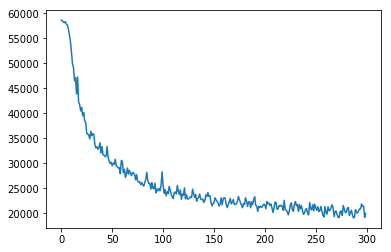

In [14]:
plt.plot(LL)
plt.show()